In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data processing

In [2]:
column_names = ['unit_number', 
                'time_in_cycles', 
                'operational_setting_1', 
                'operational_setting_2', 
                'operational_setting_3', 
                'sensor_measurement_1', 
                'sensor_measurement_2',
                'sensor_measurement_3',
                'sensor_measurement_4',
                'sensor_measurement_5',
                'sensor_measurement_6',
                'sensor_measurement_7',
                'sensor_measurement_8',
                'sensor_measurement_9',
                'sensor_measurement_10',
                'sensor_measurement_11', 
                'sensor_measurement_12', 
                'sensor_measurement_13', 
                'sensor_measurement_14', 
                'sensor_measurement_15', 
                'sensor_measurement_16', 
                'sensor_measurement_17', 
                'sensor_measurement_18', 
                'sensor_measurement_19', 
                'sensor_measurement_20',
                'sensor_measurement_21',
                'sensor_measurement_22',
                'sensor_measurement_23']


train_FD001 = pd.read_csv('train_FD001.txt', sep=' ', header=None, names=column_names)
test_FD001 = pd.read_csv('test_FD001.txt', sep=' ', header=None, names=column_names)
RUL_FD001 = pd.read_csv('RUL_FD001.txt', header=None, names=['final_RUL'])

# Drop empty columns
train_FD001.dropna(axis=1, how='all', inplace=True)
test_FD001.dropna(axis=1, how='all', inplace=True)


### Train Set

In [3]:
train_FD001.isna().sum()

unit_number              0
time_in_cycles           0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_measurement_1     0
sensor_measurement_2     0
sensor_measurement_3     0
sensor_measurement_4     0
sensor_measurement_5     0
sensor_measurement_6     0
sensor_measurement_7     0
sensor_measurement_8     0
sensor_measurement_9     0
sensor_measurement_10    0
sensor_measurement_11    0
sensor_measurement_12    0
sensor_measurement_13    0
sensor_measurement_14    0
sensor_measurement_15    0
sensor_measurement_16    0
sensor_measurement_17    0
sensor_measurement_18    0
sensor_measurement_19    0
sensor_measurement_20    0
sensor_measurement_21    0
dtype: int64

In [4]:
# Get the RUL for the train set
total_cycles = train_FD001.groupby('unit_number')['time_in_cycles'].max().reset_index()
total_cycles.rename(columns={'time_in_cycles': 'total_cycles'}, inplace=True)
train_FD001 = train_FD001.merge(total_cycles, on='unit_number', how='left')
train_FD001['RUL'] = train_FD001['total_cycles'] - train_FD001['time_in_cycles']
train_FD001 = train_FD001.drop(columns=['total_cycles'])
# Mission = 40 cycles
train_FD001['next_mission'] = train_FD001['RUL'] >= 40

In [5]:
train_FD001.head(155)

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,RUL,next_mission
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,True
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,True
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,True
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,True
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1,151,-0.0019,-0.0001,100.0,518.67,642.82,1592.39,1411.94,14.62,...,8127.21,8.4612,0.03,394,2388,100.0,38.56,23.2277,41,True
151,1,152,0.0009,-0.0001,100.0,518.67,642.67,1598.60,1420.83,14.62,...,8119.00,8.4572,0.03,395,2388,100.0,38.77,23.2369,40,True
152,1,153,0.0011,-0.0004,100.0,518.67,642.99,1589.17,1414.56,14.62,...,8124.14,8.4435,0.03,393,2388,100.0,38.78,23.1719,39,False
153,1,154,-0.0012,0.0000,100.0,518.67,642.81,1597.03,1416.07,14.62,...,8129.24,8.4794,0.03,394,2388,100.0,38.82,23.2366,38,False


In [28]:
train_FD001.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_in_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
operational_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
operational_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_measurement_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_measurement_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_measurement_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_measurement_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_measurement_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [29]:
# We remove the column with std = 0 since they don't carry information
#train_FD001 = train_FD001.drop(columns=["operational_setting_3", "sensor_measurement_18", "sensor_measurement_19"])
#test_FD001 = test_FD001.drop(columns=["operational_setting_3", "sensor_measurement_18", "sensor_measurement_19"])

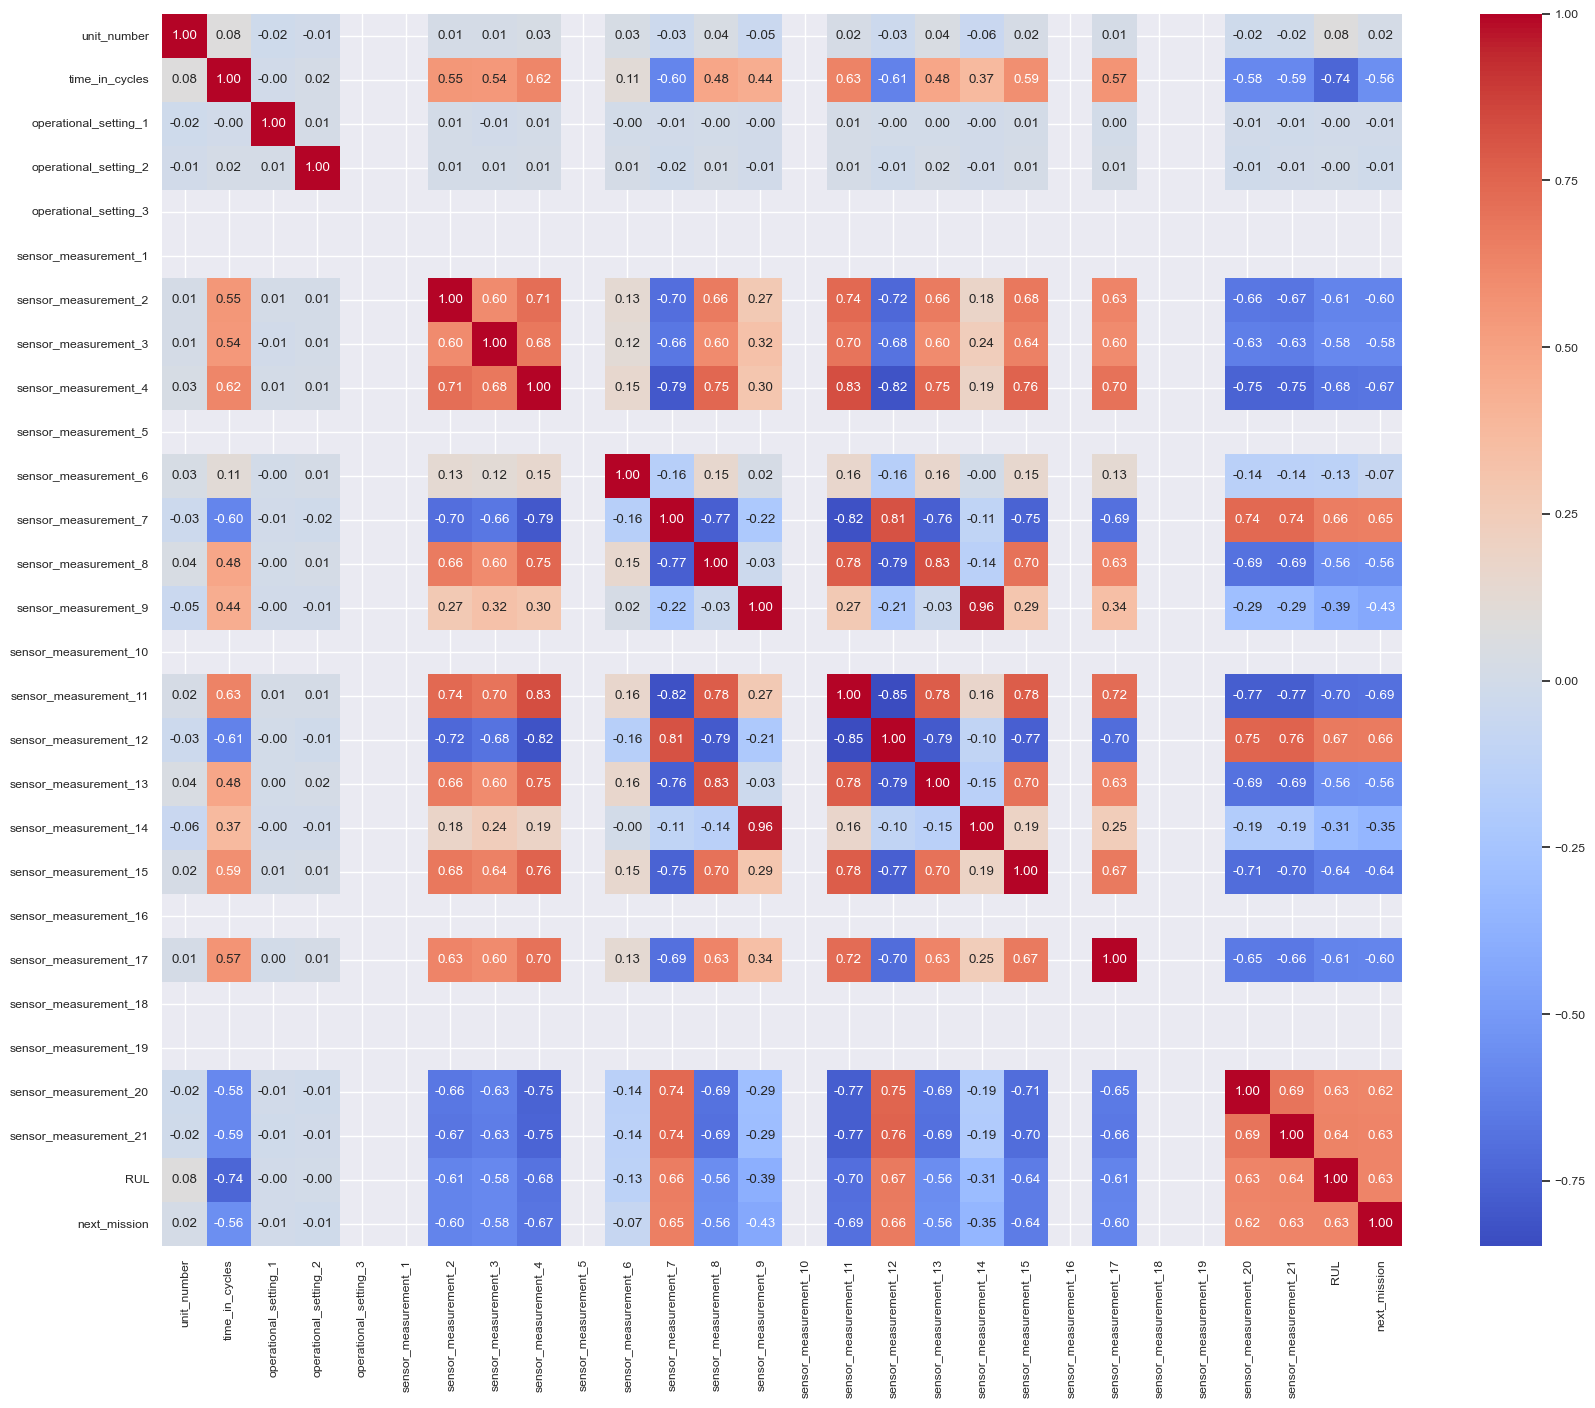

In [30]:
# calculate correlation
df_corr = train_FD001.corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(20,16))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=90)
plt.show()

### Test Set

In [31]:
# Get the RUL for the test set
RUL_FD001['unit_number'] = RUL_FD001.index + 1
test_FD001 = test_FD001.merge(RUL_FD001, on='unit_number', how='left')
test_FD001['max_cycle'] = test_FD001.groupby('unit_number')['time_in_cycles'].transform('max')
test_FD001['RUL'] = test_FD001.apply(lambda row: int(row['final_RUL'] + (row['max_cycle'] - row['time_in_cycles'])), axis=1)
test_FD001 = test_FD001.drop(columns=['max_cycle', 'final_RUL'])
# Mission = 40 cycles
test_FD001['next_mission'] = test_FD001['RUL'] >= 40

In [32]:
test_FD001.head(200)

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,RUL,next_mission
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,True
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,True
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,True
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,True
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3,116,0.0023,-0.0004,100.0,518.67,642.84,1592.18,1410.33,14.62,...,8132.20,8.4621,0.03,393,2388,100.0,38.95,23.2440,79,True
196,3,117,0.0022,-0.0005,100.0,518.67,642.61,1592.16,1418.62,14.62,...,8126.62,8.4657,0.03,395,2388,100.0,38.98,23.2925,78,True
197,3,118,-0.0019,0.0004,100.0,518.67,642.52,1596.46,1411.02,14.62,...,8129.58,8.4522,0.03,394,2388,100.0,38.76,23.2100,77,True
198,3,119,0.0057,-0.0003,100.0,518.67,643.15,1589.86,1414.47,14.62,...,8133.90,8.4591,0.03,393,2388,100.0,38.78,23.1870,76,True


In [33]:
len(train_FD001)

20631

In [34]:
test_FD001.shape

(13096, 28)

In [35]:
test_FD001.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,13096.0,51.543907,2.828942e+01,1.0000,28.0000,52.0000,76.0000,100.0000
time_in_cycles,13096.0,76.836515,5.305775e+01,1.0000,33.0000,69.0000,113.0000,303.0000
operational_setting_1,13096.0,-0.000011,2.202685e-03,-0.0082,-0.0015,-0.0000,0.0015,0.0078
operational_setting_2,13096.0,0.000004,2.940306e-04,-0.0006,-0.0002,-0.0000,0.0003,0.0007
operational_setting_3,13096.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_measurement_1,13096.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_measurement_2,13096.0,642.475088,4.008993e-01,641.1300,642.1975,642.4600,642.7400,644.3000
sensor_measurement_3,13096.0,1588.099204,5.003274e+00,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
sensor_measurement_4,13096.0,1404.735362,6.688309e+00,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
sensor_measurement_5,13096.0,14.620000,1.776425e-15,14.6200,14.6200,14.6200,14.6200,14.6200


## Training using LSTM

In [36]:
min_size = float('inf')  # Initialize to a very large number

for name, group in train_FD001.groupby('unit_number'):
    group_size = len(group)
    if group_size < min_size:
        min_size = group_size

print(f"The minimum size for a group in 'train_FD001' is: {min_size}")

min_size = float('inf')  # Initialize to a very large number

for name, group in test_FD001.groupby('unit_number'):
    group_size = len(group)
    if group_size < min_size:
        min_size = group_size

print(f"The minimum size for a group in 'test_FD001' is: {min_size}")


The minimum size for a group in 'train_FD001' is: 128
The minimum size for a group in 'test_FD001' is: 31


In [37]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_sequences_grouped(data, time_steps=1):
    grouped = data.groupby('unit_number')
    Xs, ys = [], []

    for _, group in grouped:
        features = group.drop(columns=['unit_number', 'time_in_cycles', 'RUL', 'next_mission'])
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        labels = group['next_mission'].values

        for i in range(len(group) - time_steps):
            Xs.append(features_scaled[i:(i + time_steps)])
            ys.append(labels[i + time_steps])
    
    return np.array(Xs), np.array(ys)

X_arr, y_arr = create_sequences_grouped(train_FD001, 1)


In [38]:
print(X_arr.shape)

(20531, 1, 24)


In [39]:
with tf.device('/device:GPU:0'):    
    seq_len=X_arr.shape[1]
    num_features=X_arr.shape[2]

    model = Sequential()
    model.add(LSTM(input_shape=(seq_len, num_features), units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')

    #This callback will stop the training when there is no improvement in the validation loss for 20 consecutive epochs. 
    #regularization technique as preventing overfitting, model runtime gets shorter
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    # fit model
    history=model.fit(X_arr, y_arr, epochs=200, callbacks=[callback], batch_size=32)
    len(history.history['loss']) 



Epoch 1/200

642/642 [==============================] - 18s 10ms/step - loss: 0.0739
Epoch 2/200
642/642 [==============================] - 6s 10ms/step - loss: 0.0443
Epoch 3/200
642/642 [==============================] - 6s 10ms/step - loss: 0.0381
Epoch 4/200
642/642 [==============================] - 6s 10ms/step - loss: 0.0368
Epoch 5/200
642/642 [==============================] - 7s 10ms/step - loss: 0.0362
Epoch 6/200
642/642 [==============================] - 7s 10ms/step - loss: 0.0359
Epoch 7/200
642/642 [==============================] - 6s 10ms/step - loss: 0.0355
Epoch 8/200
642/642 [==============================] - 6s 10ms/step - loss: 0.0351
Epoch 9/200
642/642 [==============================] - 7s 10ms/step - loss: 0.0346
Epoch 10/200
642/642 [==============================] - 7s 11ms/step - loss: 0.0346
Epoch 11/200
642/642 [==============================] - 7s 10ms/step - loss: 0.0350
Epoch 12/200
642/642 [==============================] - 7s 11ms/step - loss: 0.03

In [40]:
model.save('my_lstm_model_norm.h5')

C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X_test_arr, y_test_arr = create_sequences_grouped(test_FD001, 31)

# Make predictions
predictions = model.predict(X_test_arr)

# If your model outputs probabilities (e.g., if using sigmoid activation in the last layer), 
# you might need to threshold them to get binary predictions
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate metrics
accuracy = accuracy_score(y_test_arr, binary_predictions)
precision = precision_score(y_test_arr, binary_predictions)
recall = recall_score(y_test_arr, binary_predictions)
f1 = f1_score(y_test_arr, binary_predictions)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Assuming you have true labels (y_test) and predictions (binary_predictions) ready
report = classification_report(y_test_arr, binary_predictions, target_names=['Class 0', 'Class 1'])

print("\n")
print(report)


ValueError: in user code:

    File "C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\YounèsAITKETTOUT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1, 24), found shape=(None, 31, 24)


In [43]:
# Make predictions
predictions = model.predict(X_arr)

# If your model outputs probabilities (e.g., if using sigmoid activation in the last layer), 
# you might need to threshold them to get binary predictions
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate metrics
accuracy = accuracy_score(y_arr, binary_predictions)
precision = precision_score(y_arr, binary_predictions)
recall = recall_score(y_arr, binary_predictions)
f1 = f1_score(y_arr, binary_predictions)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Assuming you have true labels (y_test) and predictions (binary_predictions) ready
report = classification_report(y_arr, binary_predictions, target_names=['Class 0', 'Class 1'])

print("\n")
print(report)


642/642 [==============================] - 4s 4ms/step
Accuracy: 0.9530466124397253
Precision: 0.9730173199635369
Recall: 0.9685439477345593
F1 Score: 0.9707754805068817


              precision    recall  f1-score   support

     Class 0       0.87      0.89      0.88      4000
     Class 1       0.97      0.97      0.97     16531

    accuracy                           0.95     20531
   macro avg       0.92      0.93      0.93     20531
weighted avg       0.95      0.95      0.95     20531



In [44]:
predictions

array([[0.9960853 ],
       [0.9960278 ],
       [0.99510884],
       ...,
       [0.02483165],
       [0.03219855],
       [0.04104125]], dtype=float32)